## Coursera Capstone Project - The Battle of Neighborhoods
The notebook is also available on github https://github.com/europateam/Coursera_Capstone.git

In [2]:
import pandas as pd
import numpy as np
import decimal

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
import json

!pip install geopy
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use(['ggplot']) # optional: for ggplot-like style

!pip install folium
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

     |████████████████████████████████| 93 kB 3.5 MB/s  eta 0:00:01


#### Download LA Census Tract Locations

In [4]:
# GEOID  to connect neighbor to CENSUS DATA 
#https://usc.data.socrata.com/Los-Angeles/Census-Tract-Locations-LA-/atat-mmad
#Census Tract Locations (LA)
    
df_geo = pd.read_csv('https://usc.data.socrata.com/resource/atat-mmad.csv')

# clean-up dataframe
df_geo = df_geo.drop(['tract','location'],axis=1)
df_geo.columns = ['geoid','tract','neighborhood','latitude','longitude']
df_geo['geoid'] = df_geo.geoid.str.replace('1400000US','')
df_geo.geoid = df_geo.geoid.astype('int64')



CENTRAL_LA = ['Arlington Heights','Beverly Grove','Carthay','Chinatown','Downtown','East Hollywood','Echo Park','Elysian Park','Elysian Valley'
,'Faircrest Heights', 'Griffith Park', 'Hancock Park','Harvard Heights','Hollywood','Hollywood Hills','Hollywood Hills West'
,'Koreatown','Larchmont','Los Feliz','Mid-City','Mid-Wilshire','Pico-Union','Silver Lake','West Hollywood'
,'Westlake','Windsor Square']

# filtered by CENTRAL LA neighborhood
df_geo = df_geo[df_geo['neighborhood'].isin (CENTRAL_LA)]

df_geo = df_geo.reset_index()
df_geo.drop(['index','latitude','longitude'],axis=1,inplace=True)
df_geo.head() 

geoid   tract     neighborhood
0  6037143700  143700  Hollywood Hills
1  6037187102  187102   Elysian Valley
2  6037187200  187200   Elysian Valley
3  6037187300  187300      Silver Lake
4  6037188201  188201        Los Feliz

#### Create Neighborhood Median Income Dataframe

In [6]:
# Living Wage (2017)
# https://data.lacounty.gov/Sustainability/Living-Wage-2017-/f5es-twcr
df_wage = pd.read_csv('https://data.lacounty.gov/resource/f5es-twcr.csv')

#clean-up dataframe
df_wage = df_wage[['geoid','tractce','medincome']]
df_wage.rename(columns = {'tractce':'tract','medincome': 'income'},inplace=True)

#df_wage.shape
df_wage.head()

geoid   tract  income
0  6037204920  204920   40871
1  6037205110  205110   43063
2  6037300501  300501  101510
3  6037206050  206050   22121
4  6037205120  205120   28558

#### Create Neighborhood population Dataframe

In [7]:
# LA County Estimated Population (2016)
# https://dev.socrata.com/foundry/data.lacounty.gov/ai64-dnh8
# County of Los Angeles Estimated Population by Census Tract, City Name, Ethnicity, Gender & Age Group: CY 2016

url = 'https://data.lacounty.gov/resource/ai64-dnh8.csv'

df_pop = pd.read_csv(url)

#clean-up dataframe
df_pop.drop(['fips','cityname','service_area'],axis=1,inplace=True)
df_pop.rename(columns = {'census_tract':'tract'},inplace=True)
df_pop['total_pop'] = df_pop[['male','female']].sum(axis=1)

#df_pop.shape
df_pop.head()

tract  age_0_15  age_16_18  age_19_20  age_21_25  age_26_59  age_60_64  \
0  101110       725        163        124        346       2448        381   
1  101122       582         98         74        200       1747        362   
2  101210      1393        217        152        420       3314        351   
3  101220       602        131         93        255       1687        235   
4  101300       578        145         84        210       1937        387   

   age_65up  male  female  white  african_american  native_american  asian  \
0       723  2471    2439   2702                73               13    515   
1       769  1873    1959   2516                27                4    533   
2       724  3341    3230   3050               185                6    492   
3       523  1738    1788   1690                36               10    286   
4       894  2035    2200   3172                41                5    328   

   pacific_islander  other  multi_race  latino  total_pop  
0                 4     34         157    1412       4910  
1                 1     10         130     611       3832  
2                 4      5         238    2591       6571  
3                 1      4         112    1387       3526  
4                 3      6         158     522       4235

#### Create a combined Neighborhood Median Income & Population Dataframe 

In [8]:
# add geoid to income and popuplation dataframe. 
# It will be used to draw heat map by income / population
df_la_income = pd.merge(df_geo[['geoid','neighborhood']], df_wage, how='left', left_on='geoid', right_on='geoid')

df_la_income_pop = pd.merge(df_la_income, df_pop [['tract','white','asian','latino','total_pop']], how='left', left_on='tract', right_on='tract')

df_la_income_pop.head()

geoid     neighborhood     tract    income   white  asian  latino  \
0  6037143700  Hollywood Hills  143700.0  120278.0  2989.0  275.0   303.0   
1  6037187102   Elysian Valley  187102.0   54167.0   545.0  729.0  2030.0   
2  6037187200   Elysian Valley  187200.0   58705.0   111.0  154.0  1215.0   
3  6037187200   Elysian Valley  187200.0   58705.0   121.0  163.0  1243.0   
4  6037187300      Silver Lake  187300.0   99911.0  1739.0  636.0   788.0   

   total_pop  
0     3910.0  
1     3405.0  
2     1537.0  
3     1534.0  
4     3416.0

In [9]:
# create a rolledup income and population by neighborhood. 
# It will be used to plot income / population of neighborhood

df_neighborhood_income_pop = df_la_income_pop.groupby('neighborhood').agg(
                                {
                                     'total_pop':sum,   
                                     'white': sum,
                                     'asian': sum,
                                     'latino': sum,
                                     'income': "mean"
                                }
                            ).reset_index()

df_neighborhood_income_pop.rename(columns = {'white':'white_pop','asian':'asian_pop','latino':'latino_pop'},inplace=True)

df_neighborhood_income_pop.head()

neighborhood  total_pop  white_pop  asian_pop  latino_pop  \
0  Arlington Heights     6404.0      272.0      736.0      3820.0   
1      Beverly Grove    15458.0    12038.0     1229.0      1133.0   
2            Carthay     8158.0     5010.0      907.0      1134.0   
3          Chinatown    13655.0     2182.0     3497.0      4680.0   
4           Downtown    10674.0     3071.0     2866.0      2301.0   

         income  
0  44416.500000  
1  87642.166667  
2  85225.500000  
3  66739.000000  
4  53735.250000

In [10]:
# add latitude and longitute to each neighborhood
lat =[]
long = []
for neighbor in df_neighborhood_income_pop.neighborhood:
    address = '{}, Los Angeles CA'.format(neighbor)

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    lat.append(location.latitude)
    long.append(location.longitude)

    
df_neighborhood_income_pop['latitude'] = lat
df_neighborhood_income_pop['longitude'] = long

#df_neighborhood_income_pop.head()

#### Visualize neighborhood median income / population of neighborhoods

In [11]:
def plotBarGraph(df_data,title,y_value,y_label,bar_color, legend_on):
    
    df_data[y_value].plot(kind='bar', color= bar_color, stacked=False, figsize=(16, 6))
    plt.xlabel('Neighborhood',fontsize=16) # add to x-label to the plot
    plt.ylabel(y_label,fontsize=16) # add y-label to the plot
    plt.title(title, fontsize=24) # add title to the plot

    if (legend_on):
        colors = {'population':'blue', 'median income':'red'}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        plt.legend(handles, labels)
    else:
        plt.legend().remove()
        
    plt.show()

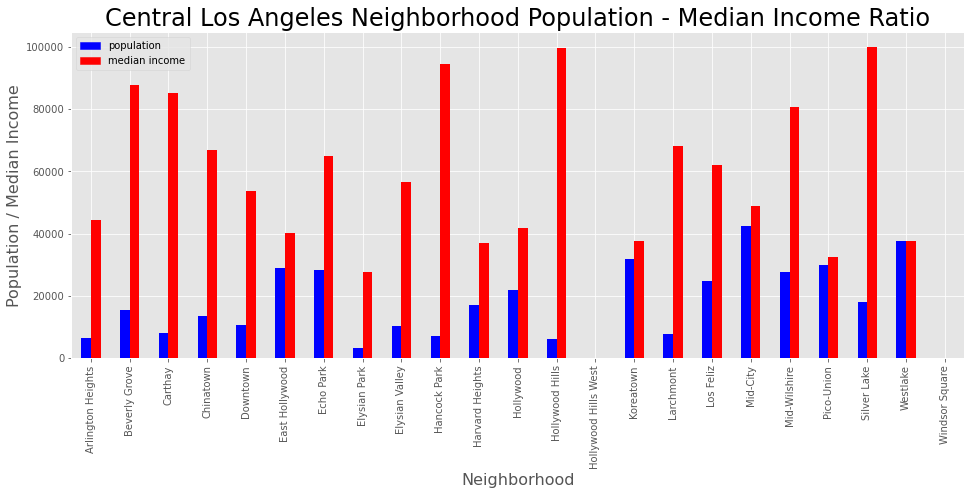

In [12]:
df_data = df_neighborhood_income_pop
df_data= df_data.set_index('neighborhood')
plotBarGraph(df_data,'Central Los Angeles Neighborhood Population - Median Income Ratio',['total_pop','income'],'Population / Median Income',['blue', 'red'], 1 )

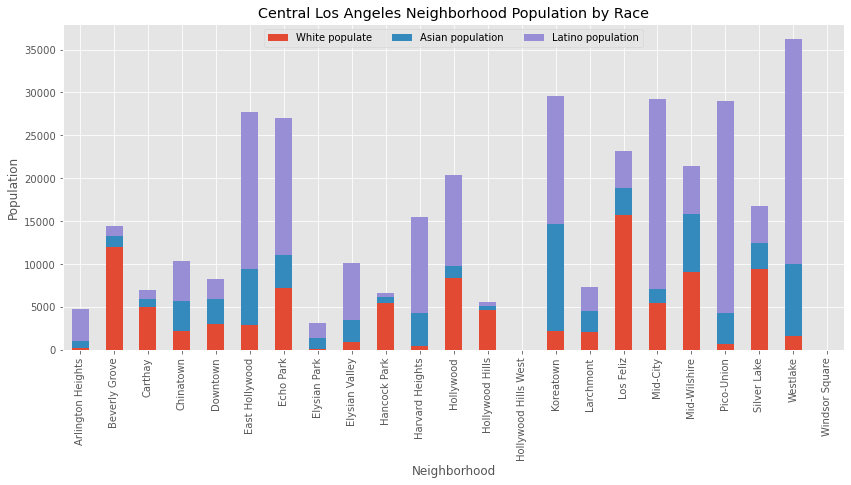

In [13]:

df_data[['white_pop','asian_pop','latino_pop']].plot(kind='bar', stacked=True, figsize=(14, 6)).legend(['White populate','Asian population','Latino population'],loc='upper center', ncol=3, title="")

#### Create visualization of neighborhood by household and income
#label_names = ['White populate','Asian population','Latino population']
#plt.legend(label_names)
plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Central Los Angeles Neighborhood Population by Race') # add title to the plot

plt.show()


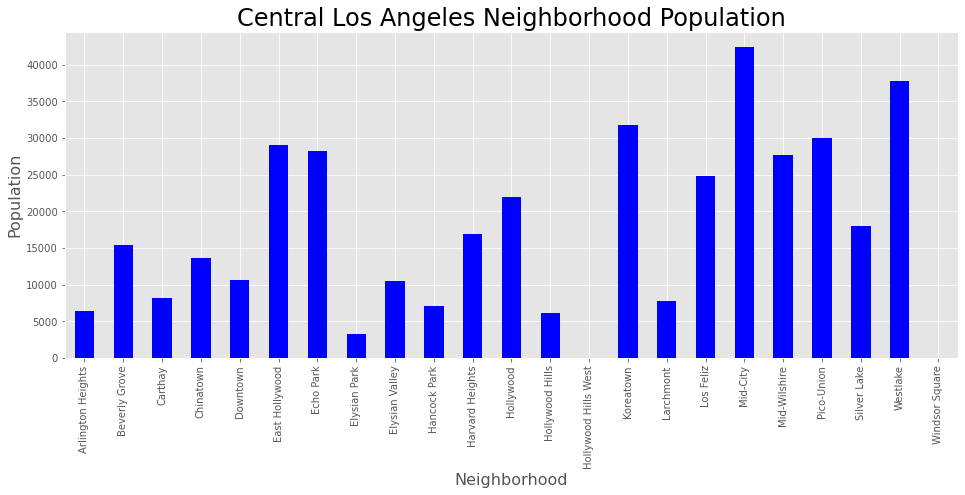

In [14]:
plotBarGraph(df_data,'Central Los Angeles Neighborhood Population',['total_pop'],'Population',['blue'], 0)

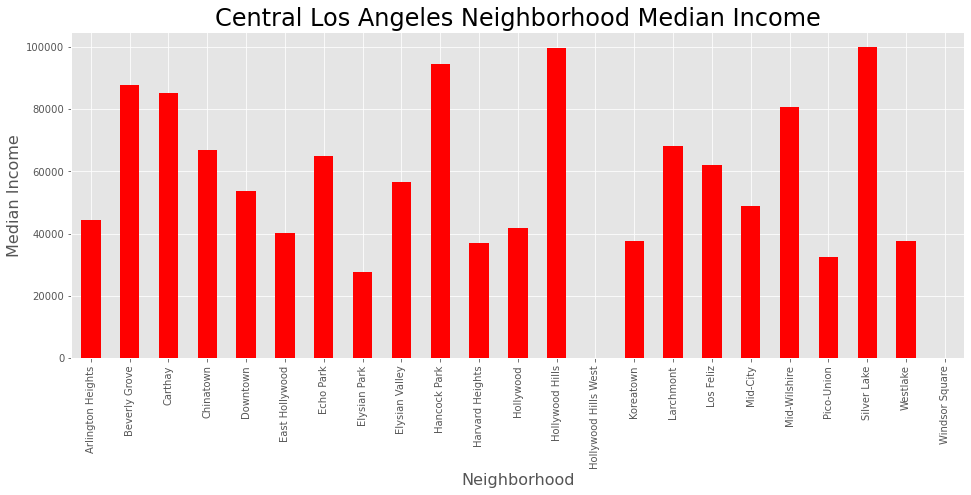

In [15]:
plotBarGraph(df_data,'Central Los Angeles Neighborhood Median Income',['income'],'Median Income',['red'],0 )

In [16]:
# choropleth map
def create_HeatMap(title,legendname, df_data, map_attribute, df_markers):
    la_geo = r'https://opendata.arcgis.com/datasets/d6c55385a0e749519f238b77135eafac_0.geojson'
    # create a plain LA map
    central_la = [34.079870, -118.311338]

    la_map = folium.Map(location=central_la, zoom_start=12,tiles='cartodbpositron')

    # generate choropleth map
    folium.Choropleth(
        geo_data=la_geo,
        data=df_data,
        columns=['neighborhood', map_attribute],
        key_on='feature.properties.name',
        fill_color='YlOrRd', 
        fill_opacity=0.7, 
        line_opacity=0.2,
        highlight=True,
        line_color='black',
        nan_fill_color="white",
        legend_name= legendname
    ).add_to(la_map)

    title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format(title)   
    la_map.get_root().html.add_child(folium.Element(title_html))

   
    if not df_markers.empty:
        
        # set color scheme for the clusters
        x = np.arange(kclusters)
        ys = [i + x + (i*x)**2 for i in range(kclusters)]
        colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
        rainbow = [colors.rgb2hex(i) for i in colors_array]


        # add markers to the map
        for lat, lon, poi, cluster, cluster_label, income, total_pop, white_pop, asian_pop, latino_pop in zip(df_markers['latitude'],\
                                                             df_markers['longitude'], df_markers['neighborhood'],\
                                                             df_markers['cluster'], df_markers['cluster_label'],\
                                                             df_markers['income'], df_markers['total_pop'],\
                                                             df_markers['white_pop'], df_markers['asian_pop'],\
                                                             df_markers['latino_pop']):

            # build label info
            
            label_text = '<h4 align="center">' + str(poi) + '</h4><b>Cluster:</b> ' + cluster_label + \
                            '<br><b>Median income:</b> $' + str(income) + \
                            '<br><b>Population:</b> ' + str(total_pop) + \
                            '<br><b>White:</b> ' + str(white_pop) + ' - <b>Asian:</b> ' + \
                            str(asian_pop) + ' - <b>Latino:</b> ' + str(latino_pop)   
            
            label_info = folium.Html(label_text,script=True)
            label = folium.Popup(label_info, max_width=400)

            folium.CircleMarker(
                [lat, lon],
                radius=6,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(la_map)

    # display map
    return la_map

In [17]:
# remove missing data
df_neighborhood_income_pop = df_neighborhood_income_pop.loc[(df_neighborhood_income_pop.total_pop != 0)]

create_HeatMap("Central LA Neighborhood Population","Population", df_neighborhood_income_pop, 'total_pop',pd.DataFrame())

#### Foursquare - explore restaurant around LA CENTRAL neighborhoods

In [18]:
# The code was removed by Watson Studio for sharing.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=750):
    
    venues_list=[]
    nearby_venues = None
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&limit={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            50,
            radius, 
            LIMIT)

        # make the GET request
        
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

        except KeyError as ke:
            pass
        
    return(nearby_venues)


In [20]:
# explore food venues 
la_venues = getNearbyVenues(df_neighborhood_income_pop.neighborhood, df_neighborhood_income_pop.latitude,df_neighborhood_income_pop.longitude,'food')

In [21]:
# classify venue category into 3 food cateogries: asian, latin, amerian/european
la_cuisine = la_venues
la_cuisine['cuisine_type'] = 'Un-Classified'

# Mexican food 
searchfor = ['Mexican','Argentinian','Brazilian','Latin','Peruvian','Spanish','Cuban'
             ,'South American']
la_cuisine.loc[(la_cuisine['Venue Category'].str.contains('|'.join(searchfor))),'cuisine_type'] = 'Latin American Food'


#la_asian
searchfor = ['Korean','Chinese','Sushi','Asian','Thai','Vietnamese','Hotpot','Dim Sum'
             ,'Indian','Noodle','Ramen','Dumpling','Filipino','Japanese','Satay','Taiwanese'
             ,'Poke','Middle Eastern','Donburi Restaurant','Cantonese','Shabu-Shabu']
la_cuisine.loc[(la_cuisine['Venue Category'].str.contains('|'.join(searchfor))),'cuisine_type'] = 'Asian Food'


#la_american
searchfor = ['Creperie','New American','French','Italian','Steakhouse','American Restaurant','Cajun'
             ,'Mediterranean','Seafood','BBQ Joint','German','Gastropub','Irish','Greek']
la_cuisine.loc[(la_cuisine['Venue Category'].str.contains('|'.join(searchfor))),'cuisine_type'] = 'American/Eurpoean Food'


# merge 3 food categories

# clean up la_venue_region
la_cuisine = la_cuisine[la_cuisine.cuisine_type!='Un-Classified']
la_neighborhood_cuisine = la_cuisine[['Neighborhood','cuisine_type']]

#la_neighborhood_cuisine

#### Analyze venues for each Neighborhood

In [22]:
# one hot encoding
la_cuisine_onehot = pd.get_dummies(la_neighborhood_cuisine[['cuisine_type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_cuisine_onehot['Neighborhood'] = la_neighborhood_cuisine['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_cuisine_onehot.columns[-1]] + list(la_cuisine_onehot.columns[:-1])
la_cuisine_onehot = la_cuisine_onehot[fixed_columns]

#la_cuisine_onehot.tail(30)

la_neighborhood_cuisine_grouped = la_cuisine_onehot.groupby('Neighborhood').mean().reset_index()
la_neighborhood_cuisine_grouped

Neighborhood  American/Eurpoean Food  Asian Food  Latin American Food
0   Arlington Heights                0.333333    0.388889             0.277778
1       Beverly Grove                0.410714    0.500000             0.089286
2             Carthay                0.437500    0.562500             0.000000
3           Chinatown                0.107143    0.732143             0.160714
4            Downtown                0.510204    0.346939             0.142857
5      East Hollywood                0.400000    0.500000             0.100000
6           Echo Park                0.360000    0.360000             0.280000
7        Elysian Park                1.000000    0.000000             0.000000
8      Elysian Valley                1.000000    0.000000             0.000000
9        Hancock Park                1.000000    0.000000             0.000000
10    Harvard Heights                0.205882    0.676471             0.117647
11          Hollywood                0.409836    0.360656             0.229508
12          Koreatown                0.109589    0.863014             0.027397
13          Larchmont                0.526316    0.263158             0.210526
14          Los Feliz                0.484848    0.424242             0.090909
15           Mid-City                0.000000    0.000000             1.000000
16       Mid-Wilshire                0.320000    0.400000             0.280000
17         Pico-Union                0.304348    0.434783             0.260870
18        Silver Lake                0.312500    0.500000             0.187500
19           Westlake                0.384615    0.461538             0.153846

In [23]:
# function returns most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_cuisine_sorted = pd.DataFrame(columns=columns)
neighborhoods_cuisine_sorted['Neighborhood'] = la_neighborhood_cuisine_grouped['Neighborhood']

for ind in np.arange(la_neighborhood_cuisine_grouped.shape[0]):
    neighborhoods_cuisine_sorted.iloc[ind, 1:] = return_most_common_venues(la_neighborhood_cuisine_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_cuisine_sorted

#### Using Elbow method to determine the optimal K-Mean

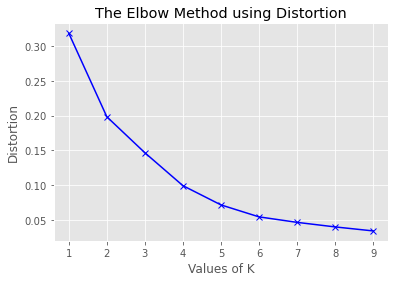

In [25]:
la_cuisine_grouped_clustering = la_neighborhood_cuisine_grouped.drop('Neighborhood', 1)
 

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(la_cuisine_grouped_clustering) 
    kmeanModel.fit(la_cuisine_grouped_clustering)     
     
    distortions.append(sum(np.min(cdist(la_cuisine_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / la_cuisine_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(la_cuisine_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / la_cuisine_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    

#for key,val in mapping1.items(): 
#    print(str(key)+' : '+str(val)) 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

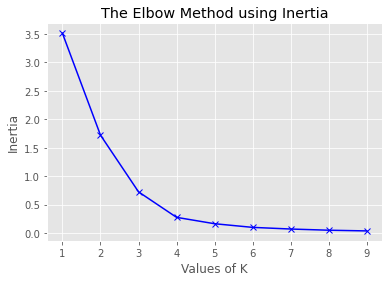

In [26]:
#for key,val in mapping2.items(): 
#    print(str(key)+' : '+str(val)) 
    
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

#### Cluster Neighborhoods

In [27]:
# based on the Elbow method to determine the optimal K-Mean
# set Kmean = 4
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_cuisine_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 


In [28]:
la_neighborhoods_cuisine_merged = pd.merge(df_neighborhood_income_pop, neighborhoods_cuisine_sorted, 
                  how='inner', left_on='neighborhood', right_on='Neighborhood')

la_neighborhoods_cuisine_merged = la_neighborhoods_cuisine_merged.drop(['Neighborhood'],axis=1)

# channge datatype
la_neighborhoods_cuisine_merged.income = round(la_neighborhoods_cuisine_merged.income,2)
la_neighborhoods_cuisine_merged.total_pop = la_neighborhoods_cuisine_merged.total_pop.astype(int)
la_neighborhoods_cuisine_merged.white_pop = la_neighborhoods_cuisine_merged.white_pop.astype(int)
la_neighborhoods_cuisine_merged.asian_pop = la_neighborhoods_cuisine_merged.asian_pop.astype(int)
la_neighborhoods_cuisine_merged.latino_pop = la_neighborhoods_cuisine_merged.latino_pop.astype(int)

# add clustering labels
la_neighborhoods_cuisine_merged.insert(0,'cluster',0)
la_neighborhoods_cuisine_merged.insert(1,'cluster_label','')
la_neighborhoods_cuisine_merged['cluster'] =  kmeans.labels_

#la_neighborhoods_cuisine_merged.head() # check the last columns!



#### Examine Cluster

In [29]:
la_neighborhoods_cuisine_merged[['cluster','neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']].head()

cluster       neighborhood   1st Most Common Venue   2nd Most Common Venue  \
0        2  Arlington Heights              Asian Food  American/Eurpoean Food   
1        2      Beverly Grove              Asian Food  American/Eurpoean Food   
2        2            Carthay              Asian Food  American/Eurpoean Food   
3        0          Chinatown              Asian Food     Latin American Food   
4        2           Downtown  American/Eurpoean Food              Asian Food   

    3rd Most Common Venue  
0     Latin American Food  
1     Latin American Food  
2     Latin American Food  
3  American/Eurpoean Food  
4     Latin American Food

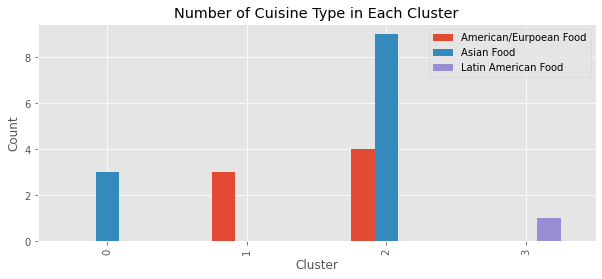

In [30]:
# visualize cuisine type distribution in each cluster
df_data = la_neighborhoods_cuisine_merged[['cluster','1st Most Common Venue']]
df_data.insert(2, 'count',1)
df_data.columns =['cluster','cuisine','count']

df_data

df_pivot = pd.pivot_table(
    df_data, 
    values="count",
    index="cluster",
    columns="cuisine", 
    aggfunc=np.sum
)

ax = df_pivot.plot(kind='bar',title='Number of Cuisine Type in Each Cluster')
fig = ax.get_figure()
fig.set_size_inches(10,4)
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.legend()
plt.show()


##### Create label for cluster after examine the clusters

In [31]:
# assign cluster label
la_neighborhoods_cuisine_merged.loc[la_neighborhoods_cuisine_merged.cluster == 0,['cluster_label']] = 'Asian Cuisine Dominant'
la_neighborhoods_cuisine_merged.loc[la_neighborhoods_cuisine_merged.cluster == 1,['cluster_label']] = 'American/European Cuisine Dominant' 
la_neighborhoods_cuisine_merged.loc[la_neighborhoods_cuisine_merged.cluster == 2,['cluster_label']] = 'Mixture of Asian - American Cuisine' 
la_neighborhoods_cuisine_merged.loc[la_neighborhoods_cuisine_merged.cluster == 3,['cluster_label']] = 'Latin American Cuisine Dominant'
#la_neighborhoods_cuisine_merged.head()

In [32]:
# cleanup unused fields
la_neighborhoods_cuisine_merged.drop(['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'],axis=1,inplace=True)

In [33]:
la_neighborhoods_cuisine_merged.head()

cluster                        cluster_label       neighborhood  total_pop  \
0        2  Mixture of Asian - American Cuisine  Arlington Heights       6404   
1        2  Mixture of Asian - American Cuisine      Beverly Grove      15458   
2        2  Mixture of Asian - American Cuisine            Carthay       8158   
3        0               Asian Cuisine Dominant          Chinatown      13655   
4        2  Mixture of Asian - American Cuisine           Downtown      10674   

   white_pop  asian_pop  latino_pop    income   latitude   longitude  
0        272        736        3820  44416.50  34.043494 -118.321374  
1      12038       1229        1133  87642.17  34.076034 -118.369972  
2       5010        907        1134  85225.50  34.061121 -118.367300  
3       2182       3497        4680  66739.00  34.063840 -118.235868  
4       3071       2866        2301  53735.25  34.042849 -118.247673

#### Create cluster visualization

In [34]:
#create_map(title,legendname, df_data, map_attribute):
create_HeatMap ('Cuisine Clusters by Median Income', 'Median Income', df_neighborhood_income_pop, 'income', la_neighborhoods_cuisine_merged )

In [35]:
create_HeatMap ('Cuisine Clusters by Population', 'Population', df_neighborhood_income_pop, 'total_pop', la_neighborhoods_cuisine_merged )

In [36]:
create_HeatMap ('Cuisine Clusters by Latino Population', 'Latino Population', df_neighborhood_income_pop, 'latino_pop', la_neighborhoods_cuisine_merged )

In [37]:
create_HeatMap ('Cuisine Clusters by Asian Population', 'Asian Population', df_neighborhood_income_pop, 'asian_pop', la_neighborhoods_cuisine_merged )

In [38]:
create_HeatMap ('Cuisine Clusters by White Population', 'White Population', df_neighborhood_income_pop, 'white_pop', la_neighborhoods_cuisine_merged )